# Chapter 2: Linear, Trend, and Momentum Forecasting
In this chapter we introduce basic tools on forecasting, which utilize simple algebraic formula. In the previous chapter, ARIMA was discussed where the future values of a time series are forecasted using its past or lagged values. It was shown that ARIMA can only be applied after removing the trend and seasonality of the data. We note however that for some forecasting tools, the trend is relevant and is part of the formula for prediction. In this work, forecasting will be demonstrated while making use of the relationships and trends in the data. 

In the first half of this notebook, we demonstrate forecasting by fitting time series data with linear regression. For the second half, we demonstrate that by using the trends of the time series data such as moving averages, we can predict the possible future direction of the trend using momentum forecasting. 

Lastly, it is important to note that the concept of moving average (MA) in ARIMA is not the same in this chapter since the moving average that will be discussed is just the classical definition of MA.

## Linear Regression Forecasting 
Linear regression forecasting is used when forecasting a time series y with the assumption that it has a linear relationship with other time series x. 

The basic equation in doing linear regression is:
$y= mx + b $

where $m$ is the slope of the linear fit and $b$ is the $y$ intercept which represents error in the fit. Usually in forecasting, $y$ is replaced by $\hat{y}$ to symbolize the forecasted value.

Given a data set, one can easily compute for the slope of the data manually or automatically using excel built-in trendline functions. To manually calculate $m$, the following equation is used:

$m = {\frac{\sum\limits _{i=1} ^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sum\limits _{i=1} ^{n}(x_{i}-\bar{x})^2}}$

To automatically calculate it in excel, one only needs to place a linear 'trendline' into the scatter plot of the data. 

This method is called the Ordinary least squares (OLS). A more general equation of LR using OLS is given as:

$y= mx + b + \mu_{i}$

where $\mu_{i}$ represent the outliers or the terms that cannot fit into the regression line.


OLS quantifies the  evaluation of different regression lines. Using OLS, the regression line that minimizes the sum of the squares of the differences between the observed dependent variable and the predicted dependent variable is chosen as the best fit. 

But what if there are outliers causing the best regression by OLS does not really fit the data? This leads us to check when OLS can be applied to a data set. The following are the assumptions that are necessarily met before we can apply OLS.


#### Gauss Markov Assumptions 
The following assumptions for sampled data (from a population) should be met so that the parameters calculated using OLS indeed represent the best unbiased estimator of the population parameters.

1. Linearity in parameters. This assumption requires that parameter $m$ is linear. (Independent variable is not required to be linear).

2. Both the independent and dependent variables $(x,y)$ are random variables. This will result to zero autocorrelation of outlier or the residual term.

3. For multivariate regression method,there should be no perfect collinearity between multiple independent variables. To test for the presence of collinearity, $R^{2}$ is good but the t-test for each variable is poor. 

4. The outlier aka residual term $\mu$ is endogenous, such that $cov(\mu_{i}, x_{i})=0$=0. 

5. Homoscedasticity in residual term $\mu_{i}$, in other words, the variance of μᵢ is independent of xᵢ.

6. The residual term $\mu_{i}$ have zero autocorrelation, i.e., $cov(\mu_{i}, \mu_{j})=0$.


Using OLS for time series data, the samples are drawn from the same process, and we can no longer assume that the independent variable x is random variable. In this case, the assumptions (4-6) should be strictly met by all $x$ at all points.


### Application: LR in Stock Price
Linear regression is one of the most successful tools used in technical analysis of prices and is widely available as a charting tool. For the sake of demonstration, I would like to use the historical data of netflix that I downloaded from yahoo.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.metrics import r2_score

%matplotlib inline
#from sklearn.model_selection 

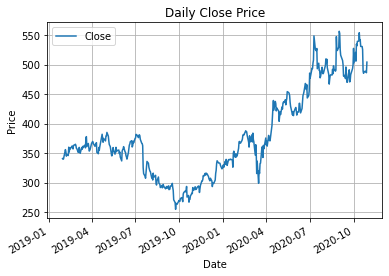

In [2]:
price = pd.read_csv('../data/NFLX3.csv',usecols=['Date', 'Close'], parse_dates=['Date'])
price.set_index("Date", inplace=True)

ax=price.plot()
plt.ylabel('Price')
plt.grid()
ax.set_title('Daily Close Price')
plt.show()

### Testing for Stationarity
One of the first steps to do when doing time series forecasting is to check the stationarity of the data, especially when there is a prominent trend. In this notebook, I will use the most widely used statistical test called the Augmented Dickey-Fuller, a unit root test. Note that a unit root test determines how strongly a time series is defined by a trend. The test uses an autoregressive model and optimizes an information criterion across different lag values.


Null Hypothesis (H0): 
- The time series has a unit root and is non-stationary. It is time dependent.

Alternate Hypothesis (H1): 
- The time series does not have a unit root and is stationary. It is not time-dependent.

Finally, the result of the test can be interpreted using the ADF Statistic, i.e., the ADF statistic should be lesser than the critical values for the data to be considered stationary.

In some references, they use p-value from the test. A p-value below a threshold (such as 5% or 1%) implies a stationary time series, otherwise the data is non-stationary.

p-value <= 0.05: The time series is stationary.

p-value > 0.05: The time series is non-stationary.


In [3]:
from statsmodels.tsa.stattools import adfuller
series = pd.read_csv('../data/NFLX3.csv',usecols=['Close'])
# series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.027586
p-value: 0.956190
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


Based on the results, the time series in non-stationary at all significance levels (1%,...) as the ADF Statistic is greater the the critical values.

### Testing for Autocorrelation
The autocorrelation coefficient measures the strength of the relationship between the data and its lag. The first coefficient measures the relationship between $y_{t}$ to $y_{t-1}$, while the second coefficient measures the relationship between $y_{t}$ to $y_{t-2}$, and so on.

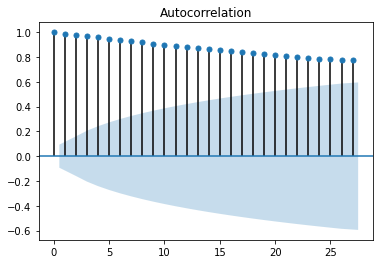

In [4]:
# testing autocorrelation using pandas tools.
tsaplots.plot_acf(price)
plt.show()

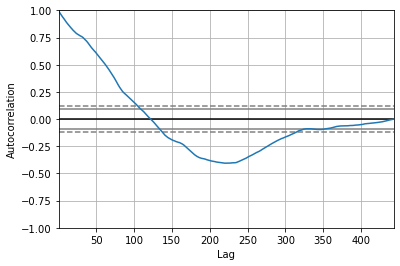

In [5]:
# testing autocorrelation using pandas tools.
autocorrelation_plot(price)

One can better imagine the concept of lagged autocorrelation if we make the lagged data as a moving version of the original data and look at the overlap (in this case, their autocorrelation). If the trends of the original are both goin up or down as the lagged data is moved, the correlation is positive, otherwise negative.

Referring back to the autocorrelation plot vs lag, the plot shows that as the lag increases, the trend decreases. The strong relationship of the data with the first 100 lags shows that $y$ is not purely random as stated in the Gauss-Markov assumption. At lag of approximately equal to 120, the autocorrelation is zero and starts to be negative. This is because the trend of the lagged data becomes negative in contrast to the positive trend of the data. 

Here we see that after approximately $y_{t-320}$, the autocorrelation is zero. This is mainly because the overlap of the lagged data and the original data is minimal as less and less data are overlapped.

Now assuming that 4-6 are met, I will apply linear regression to the price of NFLX to predict the prices for the next month on a daily basis.

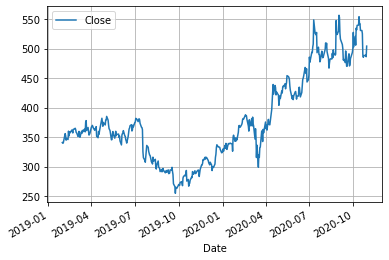

In [6]:
# Let us another variable to manipulate rather than using the original data 

window = 30
price2 = price[['Close']]#.iloc[:-window]
# price2 = price[['Close']]
price2.plot()
plt.grid()

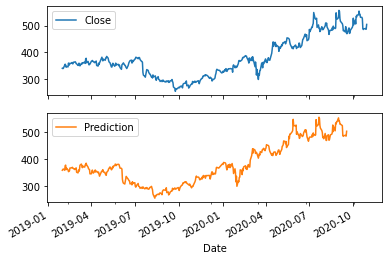

In [7]:
# With the goal of predicting the future prices daily for a month (30days), we create a variable to contain the size
# it will be placed at the end of a variable 'Prediction' in the dataframe that is shifted by 30 days

price2['Prediction'] = price2[['Close']].shift(-window)

price2.plot(subplots=True)
plt.show()

In [8]:
# Now I will use the original data on prices as X, the predicted data as y and use 80% of the data as training set 
# while 20% of the data as test set and use sklearn function to train and test the data.
# for both variables, the last 30 values are removed.

X = np.array(price2[['Close']])
X = X[:-window]
print(len(X))

y = np.array(price2['Prediction'])
y = y[:-window]
#print(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)


413


Now the data is ready for linear regression training and fitting using sklearn. 

In [9]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [10]:
# checking R^2
R_sqd = lr.score(x_test, y_test)
print("lr confidence: ", R_sqd)

lr confidence:  0.720499481096278


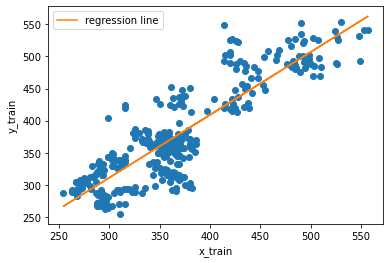

In [11]:
# To show the relationship of the training set and the predicted prices.. we plot the following.
plt.plot(x_train, y_train, 'o')
plt.xlabel('x_train')
plt.ylabel('y_train')
plt.plot(x_train.flatten(), lr.predict(x_train), label='regression line')
plt.legend()

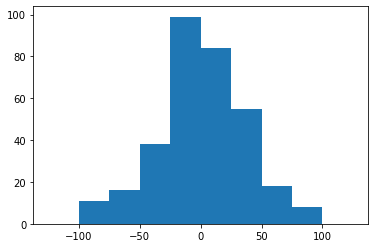

In [12]:
# An attempt to show that the difference between the training set and the predicted values are almost Gaussian
plt.hist(lr.predict(x_train)-y_train, bins=np.arange(-125, 126, 25))
plt.show()

In [13]:
# Setting the last 30 rows of the original Close price as test data 
# to predict the next values. 
x_forecast = np.array(price2.drop(['Prediction'],1))[-window:]
print(len(x_forecast))

# # we predict the closing prices...
lr_prediction = lr.predict(x_forecast)
print(len(lr_prediction))

30
30


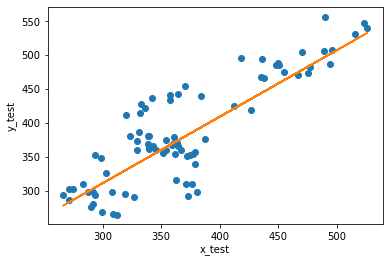

In [14]:
plt.plot(x_test, y_test, 'o')
plt.xlabel('x_test')
plt.ylabel('y_test')
plt.plot(x_test.flatten(), lr.predict(x_test))
# plt.legend()

Now, we try to plot the predicted values over the original time series.  

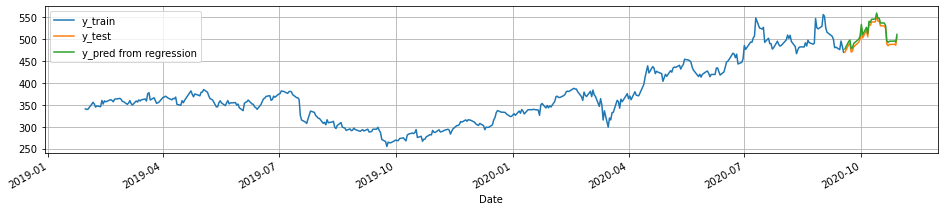

In [15]:
plt.figure(figsize=[16, 3])
price2.loc[~price2.Prediction.isnull()].Close.plot(label='y_train')
price2.loc[price2.Prediction.isnull()].Close.plot(label='y_test')
pd.Series(lr.predict(price2.loc[price2.Prediction.isnull()][['Close']].values), 
          index=price2.loc[price2.Prediction.isnull()].index, 
          name='Pred_LR').plot(label='y_pred from regression')
plt.grid()
plt.legend(loc=2)

In [16]:
# checking R^2
R_sqd_train = r2_score(y_pred=lr.predict(x_train), y_true=y_train)
print("Train set R^2: ", R_sqd_train)

## R^2 of the predicted vs the actual closing price...
R_sqd_test = r2_score(y_pred=lr_prediction, y_true=y[-window:])
print("Test set R^2: ", R_sqd_test)

Train set R^2:  0.7682299277930607
Test set R^2:  0.9187750163794522


### Compare with model where $X=X_{t-1}$

In [17]:
r2_score(price.Close.iloc[:-1], price.Close.iloc[1:])

0.9814904294769093

In [18]:
# Setting the last 30 rows of the original Close price as x_forecast as test data 
# to predict the next values. 
x_forecast2 = np.array(price2.drop(['Prediction'],1))[-window:]
# print(len(x_forecast))

# # we predict the closing prices...
lr_prediction2 = lr.predict(x_forecast2)
print(len(lr_prediction))

30


In [19]:
import scipy
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_forecast.flatten(), lr_prediction2)

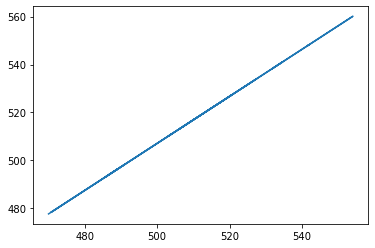

In [20]:
plt.plot(x_forecast2.flatten(), lr_prediction2)

In [21]:
x_forecast2.flatten()

array([469.959991, 487.350006, 491.170013, 470.609985, 473.079987,
       482.880005, 490.649994, 493.480011, 500.029999, 527.51001 ,
       503.059998, 520.650024, 505.869995, 534.659973, 531.789978,
       539.440002, 539.809998, 554.090027, 541.450012, 541.940002,
       530.789978, 530.719971, 525.419983, 489.049988, 485.230011,
       488.279999, 488.23999 , 488.929993, 486.23999 , 504.209991])

In [22]:
lr_prediction2

array([477.67525528, 494.71929127, 498.46329821, 478.31231748,
       480.73317812, 490.33822214, 497.95362512, 500.72733818,
       507.14701241, 534.08030122, 510.11672877, 527.35679648,
       512.87082012, 541.08801379, 538.27511811, 545.77294283,
       546.13557766, 560.13150166, 547.74296315, 548.22320466,
       537.29501338, 537.22639919, 532.03185587, 496.38545167,
       492.64147414, 495.63078181, 495.5915688 , 496.26784401,
       493.63135934, 511.24384235])

## LR for Multivariate Regression
To demonstrate LR for the case where there are more than 1 independent variable, I use a simple data

In [23]:
#creating dataframe for simple data on cars
cars = pd.read_csv('../data/cars.csv')
cars.head()

,Car,Model,Volume,Weight,CO2
0,Toyoty,Aygo,1000,790,99
1,Mitsubishi,Space Star,1200,1160,95
2,Skoda,Citigo,1000,929,95
3,Fiat,500,900,865,90
4,Mini,Cooper,1500,1140,105


In [24]:
cars.describe()

,Volume,Weight,CO2
count,36.000000,36.000000,36.000000
mean,1611.111111,1292.277778,102.027778
std,388.975047,242.123889,7.454571
min,900.000000,790.000000,90.000000
25%,1475.000000,1117.250000,97.750000
50%,1600.000000,1329.000000,99.000000
75%,2000.000000,1418.250000,105.000000
max,2500.000000,1746.000000,120.000000


In [25]:
from sklearn.linear_model import LinearRegression

# We will model C02 emission (as y variable) using the parameters volume and weight as predictors (x variable)
# for a multi-variate linear regression

params = ['Volume', 'Weight']
X = cars[params]
y = cars['CO2']

# Using scikitlearn function, train and fit the model
lrm = LinearRegression()
model = lrm.fit(X, y)

#coefficients of Linear regression model are:
b = model.intercept_
m = model.coef_

# Multivariate LR equation: y = m1x1 + m2x2 +b
# print('y=', m, 'x + ', b, '\n')

print("Our model using Multivariate Linear Regression is given by: ")
print('CO2= ', m[0], 'x1 + ', + m[1], 'x2 + ', b)

#We want to predict CO2 emission given specific weight and volume -- both 1000
model.predict([[1000, 1000]])

Our model using Multivariate Linear Regression is given by: 
CO2=  0.007805257527747122 x1 +  0.007550947270300685 x2 +  79.6947192911594


array([95.05092409])

Interpretation of coefficients:

The slope for volume and weight of the cars are equal to 0.00781 and 0.00755, respectively. This means that for every 1 unit change in volume (weight) of cars, the expected increase in CO2 emission is 0.00781% (0.00755%).

In [26]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_pred = lrm.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.67040550265231
Mean Squared Error: 40.86282453680151
Root Mean Squared Error: 6.392403658781375


Interpretation of metrics:

We can see that the value of root mean squared error is 6.392403658781375, which is less than 6% of the mean value of the CO2 emission. This means that our prediction is good.


For multi-variate linear regression, sometimes we do not know which among the parameters are relevant to the prediction. Thus in order to make our predictions more accurate, we need to penalize the less relevant parameters (or basically decrease their effect on our predictions and at times, let them approach zero). This is usually done using the concepts of regularization.

### L1 (Lasso) and L2 (Ridge) regularization for multi-variate linear regression
- proper contraining the allowed values of variables will increase the accuracy

Lasso Regularization 
- put constraints on the absolute value of the coefficients

Ridge Regularization
- put contraints on the square of the coefficients

In [27]:
# Ridge Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.1, normalize=True)
model2 = ridgereg.fit(X, y)

#coefficients of Linear regression model are:
b = model2.intercept_
m = model2.coef_

print("Our model using Multivariate L2 Linear Regression is given by: ")
print('CO2= ', m[0], 'x1 + ', + m[1], 'x2 + ', b)

Our model using Multivariate L2 Linear Regression is given by: 
CO2=  0.007019810017740837 x1 +  0.007728894654883425 x2 +  80.73020505101513


In [28]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_pred = ridgereg.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.610220319986732
Mean Squared Error: 41.142435087764326
Root Mean Squared Error: 6.414236906114735


In [29]:
# Lasso Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=0.01, normalize=True)
model3 = lassoreg.fit(X, y)


#coefficients of Linear regression model are:
b = model3.intercept_
m = model3.coef_

print("Our model using Multivariate L2 Linear Regression is given by: ")
print('CO2= ', m[0], 'x1 + ', + m[1], 'x2 + ', b)

Our model using Multivariate L2 Linear Regression is given by: 
CO2=  0.007716758354774066 x1 +  0.007406759259298172 x2 +  80.02363225450095


In [30]:
y_pred = lassoreg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.65574080048904
Mean Squared Error: 40.92513568631857
Root Mean Squared Error: 6.397275645641555


## Multi-variate Linear Regression on Climate Data
In this section, we use the climate data to demonstrate forecasting using linear regression and regularization...

In [31]:
data = pd.read_csv('../data/jena_climate_2009_2016.csv')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [32]:
data.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [33]:
X = data[['p (mbar)', 'Tdew (degC)', 'H2OC (mmol/mol)', 'rh (%)']]
y = data['T (degC)']

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [35]:
y_pred = lr.predict(x_test)

In [36]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.4932830452108559
Mean Squared Error: 0.44533245141822714
Root Mean Squared Error: 0.6673323395567062


We can see that the value of root mean squared error is 0.6673323395567062, which is less than 1% of the mean. This means that linear regression is good for this dataset with four parameters.

### L2 Regularization


In [37]:
# Ridge Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
ridgereg2 = Ridge(alpha=0.01, normalize=True)
model_temp = ridgereg2.fit(X_train, y_train)
y_pred2 = ridgereg2.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

Mean Absolute Error: 0.5059669706097649
Mean Squared Error: 0.4901795271214341
Root Mean Squared Error: 0.7001282219146961


Using L2 regularization, penalizing the other parameters didn't lead to significant improvement in the prediction.

### L1 Regularization


In [38]:
# Lasso Regularization... alpha=0 is equivalent to linear regression
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
lassoreg2 = Lasso(alpha=0.1, normalize=True)
model_temp2 = lassoreg2.fit(X_train, y_train)

In [39]:
y_pred3 = lassoreg2.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))

Mean Absolute Error: 6.873065720640884
Mean Squared Error: 71.19952837905379
Root Mean Squared Error: 8.437981297624082


L1 Regularization has the worst performance having large errors, based on the metrics.

## Momentum and Trend Forecasting Strategies in Stock Market
Now let us move to common tools in forecasting. I will discuss by considering its application in technical analysis in stock trading. The most common used tools are 
1. Moving Average
2. Momentum



### Moving Average MA

MA trading rule is the most popular trading tool for traders. The trading signal or indicator is normally derived by first computing for the average closing price over a window of size $n$, with the following formula:

$MA_{n}(t) = \frac{w_{0}P_{t}+ w_{1}P_{t-1}+ w_{2}P_{t-2}+...+ w_{n-1}P_{t-n+1}}{w_{0}+ w_{1}+ w_{2}+... + w_{n-1}}$ (1)

$MA_{n}(t) = \frac{\sum\limits _{i=0} ^{n-1} w_{i}P_{t-i}}{\sum\limits _{i=0} ^{n-1} w_{i}}$ (2)

There are three types of MA and they are as follows:
1. Simple Moving Average (SMA) - for this case, all prices are weighted equally such that $w_{i}=1$ in equations (1, 2). 

2. Linear Moving Average (LMA) - for this case, the weights change putting more relevance to the prices closer to the current price such that $w_{i}= n-i$

3. Exponential Moving Average (EMA) - similar to LMA, bigger weights are assigned to more recent prices and the weights drop exponentially. There are several ways proposed to compute the weights in EMA. I will discuss here the general formulation of EMA given as:

$EMA(n) = \frac{2}{n+1}P_{t} + (1- \frac{2}{n+1}) P_{t-1}$

Using these tools, if the current price is higher that a moving average over past $n$ periods, the signal is buy. 

Momentum on the other hand, in its simplest form, is just the difference in the current price and the price $n$ days ago. In other definitiions it can also be a change in the simple moving average with a scale factor of $N+1$:

$\frac{MOM}{N+1} = SMA_{today}- SMA_{yesterday}$

In trading, the indicators for both tools is given as:

1. Moving average:
$I_{t}(n) = P_{t}- MA_{n}$

2. Momentum
$I_{t}(n) = P_{t}-P_{t-n+1}$

The trader is suggested to buy if $I>0$ and sell otherwise.



### Extracting the Trend in Climate Data using MA
Let us try to apply MA to see the trend of the temperature measurements in the climate data. 

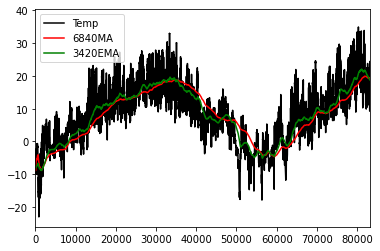

In [40]:
# 3420 data is equivalent to 1 month while 83220 is equivalent to two years, 124830 for 3 years
data['MA'] = data['T (degC)'].rolling(window=6840, min_periods=1).mean()
data['EMA'] = data['T (degC)'].ewm(span=3420, adjust=False).mean()

data['T (degC)'].plot(color = 'k', label= 'Temp')
data['MA'].plot(color = 'r', label= '6840MA')
data['EMA'].plot(color = 'g', label= '3420EMA')
plt.xlim([0, 83220])
plt.legend(loc='upper left')

Indeed there is a seasonal trend of temperature measurements and at this point, we might be interested to know which among the factors in the data are causing this trend in temperature. This concept is called causation and it will be discussed at a later chapter.

### Momentum Strategies
Momentum is used as a measure of strength of the current or future trend regardless of the direction, i.e., whether it will go up or down. It is purely a technical analysis technique and does not consider the fundamentals of the company. Traders use momentum strategy for short-term, when the trends are strong or when the price action momentum is high. An indicator of high momentum is the price advancing or declining over a wide range in a short period of time. High levels of momentum indicates increased volatility, too.

Momentum investors tries to understand and anticipate the behavior of the market, since awareness of the biases and emotions of other investors make the momentum investing strategy to work better.

Momentum strategy:
1. A trader checks the existence of trends using indicators such as trend lines, moving averages, and  ADX to identify the existence of a trend.
2. As the trend gains momentum – strengthens – the trader decides what position to take following the direction of the trend (buy an uptrend; sell a downtrend).
3. A trader exits when the momentum of the trend shows signs of weakening. Divergence between price action and the movement of momentum indicators such as the MACD or RSI is a usual indicator.

### Momentum Trading Strategy Using Two MA's
As mentioned above, momentum strategy can be applied after checking for trends using moving averages. SMA and EMA are widely used in technical analysis of stock prices and in generating buy/sell signals. The basic idea is to use two different windows (short and long observation window) and see where the two MA's cross over. A shorter window reacts faster to price changes than a longer window. Thus if MA(n=short) > MA(n=long), the trading strategy or signal is to buy. Otherwise, the signal is to sell. 

SMA works fine in technical analysis however, it's behavior lags the current price by $n/2$ days. This means that the changes in the trend can only be seen after the lag days making the strategy being delayed. EMA reduces this lag significantly as weights are decaying exponentially. The same strategy of looking for crossovers between two EMAs with short and long window of observation. A signal to buy/sell is generated when the EMA with shorter/longer window crosses above/below the EMA with longer observation window.

Now let me demonstrate using the Netflix data, how to use MA and EMA in making signals or decisions whether to buy or sell the stock.


Text(0, 0.5, 'Price')

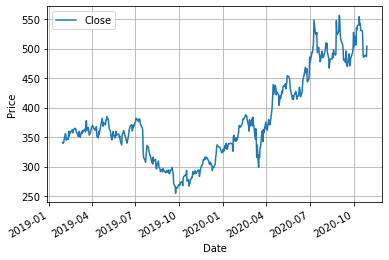

In [41]:
# Recall Netflix data we used above in forecasting using linear regression (LR)
price.plot()
plt.grid()
plt.ylabel('Price')

In [42]:
## In pandas, the rolling windows is available in computing for the mean of a window sized-n. 
price['20MA'] = price['Close'].rolling(window=20, min_periods=1).mean()
price['65MA'] = price['Close'].rolling(window=65, min_periods=1).mean()

We will try to locate the crossover of the two MAs and create an 'indicator' of crossover. Note that this indicator is not exactly the same as the indicator I above. Afterwhich, we will create our strategy based on the generated indicators.. The strategy is based on the movement of price.

If MA20> MA65, we have indicator equal to +1.0, otherwise indicator equal to 0.0. Once there is a crossover, there is a reversal of the positions of MA20 and MA65. Thus getting the difference between the indicators ($I_{diff} = I_{t} - I{t-1}$) for two consecutive times will tell us if the reversal is positive (buy) or negative (sell).

In [43]:
price['Indicator'] = 0.0
price['Indicator'] = np.where(price['20MA']> price['65MA'], 1.0, 0.0)

# To get the difference of the indicators, we use function diff in pandas.
price['Decision'] = price['Indicator'].diff()
# print(price)

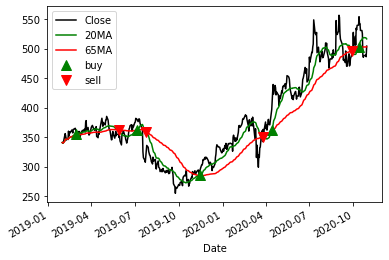

In [44]:
#Decision=+1 means buy, while Decision=-1 means sell
# plotting them all together 
price['Close'].plot(color = 'k', label= 'Close')
price['20MA'].plot(color = 'g', label = '20MA')
price['65MA'].plot(color = 'r', label = '65MA')

plt.plot(price[price['Decision'] == 1].index, price['20MA'][price['Decision'] == 1], '^', markersize = 10, color = 'g' , label = 'buy')
plt.plot(price[price['Decision'] == -1].index, price['20MA'][price['Decision'] == -1],  'v', markersize = 10, color = 'r' , label = 'sell')
plt.legend(loc='upper left')

Using two MA's and getting their crossover or difference as indicator, we can decide whether to buy (green) the stock or sell (red). We can do the same process we did above using EMA.

In [45]:
# In pandas, the rolling window equivalent for EMA is 
price['20EMA'] = price['Close'].ewm(span=20, adjust=False).mean()
price['65EMA'] = price['Close'].ewm(span=65, adjust=False).mean()

In [46]:
print(price)

                 Close        20MA        65MA  Indicator  Decision  \
Date                                                                  
2019-01-30  340.660004  340.660004  340.660004        0.0       NaN   
2019-01-31  339.500000  340.080002  340.080002        0.0       0.0   
2019-02-01  339.850006  340.003337  340.003337        0.0       0.0   
2019-02-04  351.339996  342.837502  342.837502        0.0       0.0   
2019-02-05  355.809998  345.432001  345.432001        0.0       0.0   
...                ...         ...         ...        ...       ...   
2020-10-23  488.279999  518.695998  502.764923        1.0       0.0   
2020-10-26  488.239990  518.575497  502.884768        1.0       0.0   
2020-10-27  488.929993  518.347997  502.781384        1.0       0.0   
2020-10-28  486.239990  517.658496  502.746460        1.0       0.0   
2020-10-29  504.209991  516.493495  503.049999        1.0       0.0   

                 20EMA       65EMA  
Date                                
20

In [47]:
# Like how we used MA above, we will try to locate the crossover of the two EMAs and create an indicator of crossover 
price['Indicator_EMA'] = 0.0
price['Indicator_EMA'] = np.where(price['20EMA']> price['65EMA'], 1.0, 0.0)

price['Decision_EMA'] = price['Indicator_EMA'].diff()
# print(price)

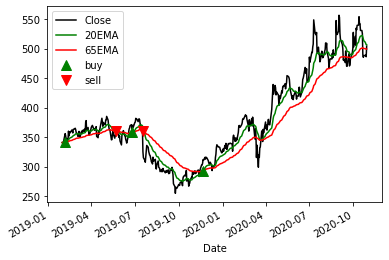

In [48]:
# Decision=+1 means buy, while Decision=-1 means sell
# plotting them all together 
price['Close'].plot(color = 'k', label= 'Close')
price['20EMA'].plot(color = 'g', label = '20EMA')
price['65EMA'].plot(color = 'r', label = '65EMA')

plt.plot(price[price['Decision_EMA'] == 1].index, price['20EMA'][price['Decision_EMA'] == 1], '^', markersize = 10, color = 'g' , label = 'buy')
plt.plot(price[price['Decision_EMA'] == -1].index, price['20EMA'][price['Decision_EMA'] == -1],  'v', markersize = 10, color = 'r' , label = 'sell')
plt.legend(loc='upper left')

For this cases, the momentum indicators generally helps us generate decisions whether to buy or not. The crossover is a sign of reversal of trend. In the context of technical analysis, "To buy" predicts that the price will increase, while "To Sell" predicts that the price will decrease.

These tools work in general but there are more sophisticated tools that can be used in doing technical analysis.


### Other Momentum Indicators: MACD
The Moving Average Convergence Divergence (MACD) is one of the most popular momentum indicators, which makes use of the difference between two exponential moving averages (12-day and 26-day) and compare it with another EMA (9-day).

1. bullish crossover (buy) -  occurs when MACD crosses above the signal line. 
2. bearish signal (sell) - MACD crosses below the signal line. 
3. overbought or oversold - crossover has a high sloping MACD, depending on if the crossover is bullish or bearish respectively. A correction or reversal of direction will soon follow.
4. on movement - weak movement, indicated by the small slope of MACD has a high chance to correct while a strong movement highly probable to continue.


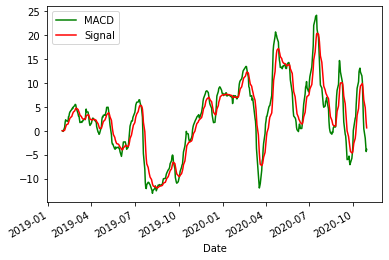

In [49]:
price['exp1'] = price['Close'].ewm(span=12, adjust=False).mean()
price['exp2'] = price['Close'].ewm(span=26, adjust=False).mean()
price['macd'] = price['exp1']-price['exp2']
price['exp3'] = price['macd'].ewm(span=9, adjust=False).mean()

price['macd'].plot(color = 'g', label = 'MACD')
price['exp3'].plot(color = 'r', label = 'Signal')
plt.legend(loc='upper left')

plt.show()


In the plot above, we can see the dates where a bullish (or a bearish) crossover happened. Now we want to examine the strength and identify overbought and oversold conditions. Here we use the same parameters, but we plot the original price and its MACD.

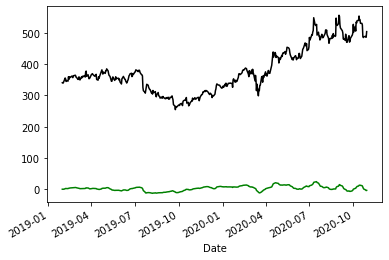

In [50]:
price['Close'].plot(color = 'k', label= 'Close')
price['macd'].plot(color = 'g', label = 'MACD')
plt.show()

Here, MACD stays somehow flat but notice that there are times where the MACD curve is steeper than other times, indicative of overbought or oversold conditions (e.g. before 2020-04).  Zooming-in to the MACD plot to see the slopes, we have the ff:

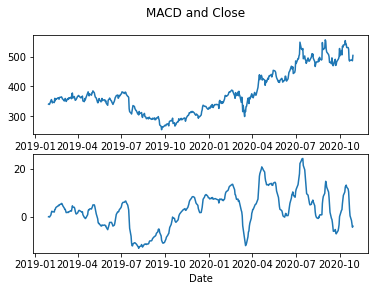

In [51]:
fig, axs = plt.subplots(2)
fig.suptitle('MACD and Close')
axs[0].plot(price['Close'], label='Close')
axs[1].plot(price['macd'], label='macd')
for ax in axs.flat:
    ax.set(xlabel='Date')

From the above plots, the steep slopes of MACD happened before 2020-04 (oversold) and 2020-10 (overbought). Note that there are still some steep sloped in MACD after 2020-07 and could be indicative of other instances of overbuying and overselling. 

Finally, as discussed above, there are other momentum indicators that are used in trading such as RSI and ADX. The reader is left to explore on them following the procedure presented in this notebook.

## Preview to the next chapter...
In this chapter we discussed and demonstrated how we can use forecasting tools such as linear, trend, and momentum. Compared to the previous chapter, we noted here that there is no need to check for the stationarity of the time series not for differencing. We also showed that linear regression (and multi-variate LR) is limited and performs poorly when applied to some data such as the climate data. Following this, the next chapter will introduce us to the concept of vector autoregressive model (VAR) which is pressumed to be a better tool in forecasting time series data since it can incorportate information from the previous time step of another data. 

Finally we emphasized that while other forecasting tools require the removal of trends, in this notebook we showed that trends can be utilized to predict the future direction of the data.


### References:
The discussions in this notebook were made with the help of the following references
1. https://www.tandfonline.com/doi/pdf/10.1080/14697688.2020.1716057?needAccess=true
2. https://towardsdatascience.com/introduction-to-linear-regression-in-python-c12a072bedf0
3. https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089
4. https://otexts.com/fpp2/autocorrelation.html
5. https://www.w3schools.com/python/python_ml_multiple_regression.asp
6. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
7. https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a
8. https://www.investopedia.com/articles/trading/09/linear-regression-time-price.asp
9. https://medium.com/@harishreddyp98/regularization-in-python-699cfbad8622
10. https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
11. https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/momentum-investing/